In [160]:
#import sys
#sys.setrecursionlimit(3000)
from graphillion import GraphSet
import networkx as nx
import graphillion.tutorial as tl 
#define graphset params and set universe as fully connected graph with N nodes
#GraphSet.converters['to_graph'] = nx.from_edgelist
#GraphSet.converters['to_edges'] = nx.to_edgelist
import tkinter
import matplotlib as mpl
import networkx as nx
import algorithmx
#mpl.use('TkAgg')
import matplotlib.pyplot as plt

import numpy as np
import copy
import random
import os
import warnings
import scipy
import math
import array
import copy

from itertools import islice
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF, renderPM
from random import randint
from IPython.display import SVG

from sknetwork.topology import connected_components
from sknetwork import topology
#import sknetwork as skn

#import sys
#print(sys.modules.keys())
#from importlib import reload
#reload(skn)
from sknetwork.visualization import svg_graph
from scipy import sparse
#import pandas as pd

#from sknetwork.data import convert_edge_list, load_edge_list
from IPython.display import display

from qdpy.plots import *
from qdpy import containers
from qdpy.algorithms.deap import *
from qdpy.containers import *
from qdpy.benchmarks import *

from qdpy.base import *

from deap import base
from deap import creator
from deap import tools
from deap import algorithms
from itertools import chain
from itertools import islice
from random import randint
from sklearn.neighbors import NearestNeighbors,BallTree,KDTree

N = 7 #nbr of enclaves scale other parameters from base: N=5, M=30, T=20, times_share = [1,1,1,1]
#set universe
#complete_n = nx.complete_graph(N)
#GraphSet.set_universe(complete_n) #all subgraphs of the complete graph with N enclaves
#degree constraints
#degree_constraints = {2:1,4:1} #E2 and E4 can NOT route traffic => degree is 1
#gs = GraphSet.graphs(degree_constraints=degree_constraints) #gs = set of graphs with constraints
#myit = gs.rand_iter() #iterator over set of constrained graphs
M = 10 #nbr of valuable machines
pe = 0.7 #error rate of IDS
T = 36 #simulation time #24 for N5 36 for N7
#r = 0.3 #passive reconnaissance device discovery percentage over time
recon_percentage = 0.7 #how much time percentage to spend on recon
penalty_coeff = 0.01 #how much weight we put on penaly term 
#times = [16,12,14,8] #sum <= T, time to spend in each enclave except the Internet enclave E0
times_shares = [1]*(N-1) #times_share : 3 times share units in E1... their are T is divided between the shares (see coevolutionary algo)
times_sum = sum(times_shares)
times_share = int(T/times_sum)
times = [t*times_share for t in times_shares] #convert it into times
times[-1] += T-sum(times)
#times = [4,4,3,4,3,4,4,4,3,4,4,4,3,4,4,4] #for N=16
#times = [4, 5, 4, 4, 5, 4, 5, 4, 5]
nb_routers = 3 #nbr of enclaves that can route traffic
route_traffic = [1,1,1,0,0,0] #only E1,E2,E3 can route traffic, others cant
print("len times = ",len(times))
print("sum times = ",sum(times))
print("times = ",times)
beta = 2 #attacker spread in enclave original beta = 3
c = 0.9 #compromise appetite
a = 0.4 #information appetite original 0.4
mission_impact = [(0.9,0.9) for i in range(M)] #list of mission impact and information impact for valuable machines 
mission_impact += [(0.9,0.9)]  #mission impact and information impact of firewall (Mth machine)
pupdate = 1/90 #update rate of each enclave
JUNK_MACHINES_NB = 20 #nbr of useless machines to add in enclave
#mi !=0 !!!! greater mission impact => greater back up time
print("ENCLAVE JUNK_MACHINES_NB = ",int(JUNK_MACHINES_NB/2))
for i in range(JUNK_MACHINES_NB):
    mission_impact += [(0.1,0.5)] # useless machines have at least 3 turns back up time(see turned_down dict), low compromise dmg and poor information dmg
    
def CVSS_sample():
    hist = [703,914,4880,4556,27455,23785,17054,27369,553,16185] #src : CVSS distribution https://www.cvedetails.com/cvss-score-distribution.php
    return np.random.choice(list(range(1,11)),1,p = [float(h/sum(hist)) for h in hist])[0]/10

global_vulnerabilities = [CVSS_sample() for j in range(N)]
global_vulnerabilities = [0,0.48,0.762,0.827,0.762]#coevolv paper for N5
global_vulnerabilities = [0,0.5,0.6,0.8,0.7]#experimental : 2 small vuln, 2 high for N5
global_vulnerabilities = [0,0.5,0.6,0.8,0.7,0.9,0.8] #2 small, 4 high for N7
print(global_vulnerabilities)


#GRAPH CONSTRAINED SPACE
GraphSet.converters['to_graph'] = nx.from_edgelist
GraphSet.converters['to_edges'] = nx.to_edgelist

complete_n = nx.complete_graph(N)
GraphSet.set_universe(complete_n) #all subgraphs of the complete graph with N enclaves
#degree constraints
degree_constraints = {0:1,1:1,2:1} #deg 1 can NOT route traffic => access router. Internet has degree 1
edge_constraints = [(4, 6)] #edge constraints
gs_edge_constraints = GraphSet({'include': edge_constraints})
connected_vertices =  list(range(0,N)) #all vertices must be connected
gs = GraphSet.graphs(vertex_groups = [connected_vertices],degree_constraints=degree_constraints,graphset=gs_edge_constraints) #gs = set of graphs with constraints
#myit = gs.rand_iter() #iterator over set of constrained graphs
print("There are",len(gs),"constrained graphs")

iter_obj = iter(gs) #build list of constrained graphs
g_array = []
while True:
    try:
        graph = next(iter_obj)
        adjacency = np.array(nx.to_numpy_matrix(graph, nodelist=sorted(graph.nodes())))
        g_array.append(get_topo(adjacency))
    except StopIteration:
        break

len times =  6
sum times =  36
times =  [6, 6, 6, 6, 6, 6]
ENCLAVE JUNK_MACHINES_NB =  10
[0, 0.5, 0.6, 0.8, 0.7, 0.9, 0.8]
There are 1536 constrained graphs


In [2]:
#####SIMULATION#######

class enclave:
    def __init__(self,v,s,machines,adjacency):
        self.v = v
        self.sens = s
        self.machines = {m:0 for m in machines}#0 means not infiltrated
        self.machines[M] = 0 #Mth machine represents the firewall
        n_to_add = random.randint(0,JUNK_MACHINES_NB)#nbr of useless machines to add
        for useless in range(M+1,M+1+n_to_add): #add some useless machines
            self.machines[useless] = 0
        self.compromised = False#compromised if attacker is in 
        self.next_hops = list(np.where(np.array(adjacency)==1)[0]) #indexes of connected enclaves to enclave
        
def get_adj(topo):
    adj = np.zeros((N,N))
    index = 0
    count = N-1
    topi = 0
    for i in range(N):
        adj[i][index+1::] = topo[topi:topi+count]
        index +=1
        topi += count
        count -=1
        
    for i in range(N):  #other side of diagonale should be zero or symetric ?
        for j in range(N):
            adj[j][i] = adj[i][j]
    #print(adj)
    return adj
    
def connected_components(adjacency):
    return sparse.csgraph.connected_components(adjacency, False, 'weak', True)[1]

def init(ind):
    #print("ind = ",ind)
    topo = ind[0]
    sensitivities = ind[1]
    sensitivities_decoded = [0]+sensitivities #default vulnerability of the internet enclave
    distr = ind[2]
    distr_decoded = [[]] + distr#default no machines in the internet
    adj = get_adj(topo)
    #v = [CVSS_sample() for j in range(N)]
    #global_vuln or v ? => I want to sample vuln once and for all to see where the algo puts each enclave
    enclaves = [enclave(global_vulnerabilities[i],sensitivities_decoded[i],distr_decoded[i],adj[i]) for i in range(N)]
    
    adj_sk = sparse.csr_matrix(adj)
    labels = connected_components(adj_sk)
    dist_matrix = sparse.csgraph.shortest_path(adj_sk,directed = False)
    d_max = np.max(dist_matrix)
    #print("dist_matrix = ",dist_matrix)
    nodes_weights = [len(distr_decoded[node]) for node in range(N)] #more machines => grater weight
    penalty_term = sum([nodes_weights[node]*dist_matrix[node][0] for node in range(N)])
    #print("penalty_term = ", penalty_coeff*penalty_term)
    #if(np.sum(labels)>0):
        #print("unvalid architecture")
    #print("sens = ",ind[1])
    #print("distr_machines = ",ind[2])
    #names = ["Internet"]+["E"+str(i)+" s = "+str(sensitivities[i-1])+" nbr_machines = "+str(distr[i-1])+" v = "+str(global_vulnerabilities[i]) for i in range(1,N)]
    #image = svg_graph(adj_sk,labels=labels,names=names)
    #x=SVG(image)
    #display(x)
    loss = attack(enclaves,T,times)
    #print("attack term = ",loss)
    loss -= penalty_coeff*penalty_term
    #print("total loss = ",loss)
    return loss

def attack(enclaves,T,times):
    total_time = 0
    loss = 0
    internet = enclaves[0]
    internet.compromised = True
    compromised_enclaves_index = [0]
    already_compromised = [0] #enclaves that have been compromised in the past
 
    #internet starting point : useless ? start 
    """
    for e_index in internet.next_hops: #epidemic spread throughout enclaves
        e = enclaves[e_index]
        if (not e.compromised) and (not e_index in already_compromised):#dont spread to already compromised enclaves...
            infect = random.random()
            Network_IDS_intercept = random.random()
            print("internet_next_enclave_to_compromise = ",e_index)
            if infect < e.v and Network_IDS_intercept < pe: #vuln exploited and IDS failed to block
                print("success enclave infiltration")
                loss += spread(e,times[len(compromised_enclaves_index)-2])

                if(e.compromised): #enclave can be no longer compromised after failed spread
                    compromised_enclaves_index.append(e_index)

                already_compromised.append(e_index) #add infected enclave to already compromised list
                total_time += times[len(compromised_enclaves_index)-2]
                if (total_time >= T):
                    return loss
            else:
                print("failed enclave infiltration")
        total_time += 1
    """
    #print("times = ",times)
    while total_time < T:
        #print("time = ",total_time," / ",T)
        #print("compromised_enclaves_index = ",compromised_enclaves_index)
        for e in compromised_enclaves_index: 
            #print("current_compromised_enclave = ",e)
            enclave = enclaves[e]
            #print("enclave.next_hops = ",enclave.next_hops)
            for next_hop_index in enclave.next_hops:
                enclave_next_hop = enclaves[next_hop_index]
                #print("already compromised = ",already_compromised)
                if (not enclave_next_hop.compromised):#dont spread to compromised enclaves...
                    #print("next_hop_index_tentative = ",next_hop_index)
                    infect = random.random()
                    Network_IDS_intercept = random.random()
                    if infect < enclave_next_hop.v and Network_IDS_intercept < pe: #vuln exploited and IDS failed to block
                        #print("success enclave infiltration")
                        #can spread to already compromised enclaves in the past, but can't get information gain
                        loss += spread(enclave_next_hop,times[next_hop_index-1],not (next_hop_index in already_compromised))
                        already_compromised.append(next_hop_index) #add infected enclave to already compromised list
                        #even if later recovered by cleansing
                        if(enclave_next_hop.compromised): #enclave can be no longer compromised after failed spread
                            compromised_enclaves_index = copy.deepcopy(compromised_enclaves_index)
                            #deepcopy to prevent affecting the for loop dynamically
                            compromised_enclaves_index.append(next_hop_index)
                        total_time += times[next_hop_index-1] #time to spend in enclave next_hop_index
                        if (total_time >= T):
                            return loss
                    #else:
                        #print("failed enclave infiltration")
        total_time += 1
        #print("time incremented")
    return loss
            

#enclave spread
def spread(enclave,time,info_loss_to_get):
    #print("info_loss_to_get = ",info_loss_to_get) #if enclave already compromised, no info loss to get
    enclave.compromised = True
    loss = 0 #loss 
    recon_time = int(recon_percentage*time)  #recon time
    machines_index = list(enclave.machines.keys()) #machines in enclave
    #print("machines_index = ",machines_index)
    n_machines = len(machines_index) #nbr machines in enclave
    
    first_infected = np.random.choice(machines_index,1)[0] #the first machine to be infected is drawn uniformly between all machines in enclave
    enclave.machines[first_infected] = 1 #machine infected
    already_infected = {m:0 for m in machines_index} #machines infected at some point even if back up later after compromise
    already_infected[first_infected] = 1
    discovered_machines_index = [first_infected] #list of discovered machines 
    
    #convert mission impact in 0,1 to back up time by multiplying it by 10
    turned_down = {m:[False,max(3,int(mission_impact[m][0]*10))] for m in machines_index}#turned down machines and their mission delay time
    #print("turned_down = ",turned_down)
    #to indicate how much time left before back up
    #max so that at least 3 turns to put a junk machine back up so attacker has time to spread
    #prior values of machines
    total_prior_values = {m:a*0.2*int(info_loss_to_get)+c*0.2 for m in machines_index} #prior values of machine, default = pessimistic
    
    
    #reconnaissance FIRST
    #print("time = ",time)
    #print("recon_time = ",recon_time) 
    for t in range(recon_time):
        #print("t= ",t, " / ",time)
        update = random.random()
        if (update < pupdate): #"pseudo probability of enclave update"
            for key in enclave.machines.keys(): #every machine in enclave no longer compromised
                enclave.machines[key] = 0
            enclave.compromised = False
            #print("update !!")
            #print("loss = ",loss)
            #print("spread done")
            return loss
        #print("recon...")
        not_discovered = list(set(machines_index)-set(discovered_machines_index))
        if(len(not_discovered)>0): #if there are some machines left to discover
            discovered_machine = np.random.choice(not_discovered,1)[0]
            discovered_machines_index += [discovered_machine]
            total_prior_values[discovered_machine] = a*mission_impact[discovered_machine][1]*int(info_loss_to_get)+c*mission_impact[discovered_machine][0]

    
    #information stealing and(maybe) shutting down of this first machine (its mission service)
    #print("first machine infected : ",first_infected)
    loss -= a*mission_impact[first_infected][1]*int(info_loss_to_get) #update information loss
    #print("loss of first machine = ",loss)
    #compromise or not ??? => more likely if high compromise value and compromise appetite
    compromise_pseudo_proba = (c+3*mission_impact[first_infected][0])/4#put more weight on mission impact
    compromise = random.random()
    if compromise < compromise_pseudo_proba:
        #print("first machine turned down : ",first_infected)
        turned_down[first_infected][0] = True
        nbr_turned_down = len([m for m in list(turned_down.keys()) if turned_down[m][0]])
        threshold = nbr_turned_down * enclave.sens
        if random.uniform(0,n_machines)<threshold: #when turned down treshold reached : enclave cleansing 
            #print("enclave cleansing due to many downed (only first) machines")
            for key in enclave.machines.keys(): #every machine in enclave no longer compromised
                enclave.machines[key] = 0
            enclave.compromised = False #enclave no longer compromised
            loss -= sum([mission_impact[m][0] for m in machines_index])/2 #half mission delay for all machines 
            #because there is no detection and investigation time
            #print("loss after only first down = ",loss)
            #print("spread done (first only)")
            return loss 
        else:
            loss -= c*mission_impact[first_infected][0] #update turned down loss
            #print("loss = ",loss)
            #machine to be back up after mission delay time and no longer infected
    
    if(len(machines_index)==1): #enclave only has one firewall-IDLE machine, return default loss
        #print("loss = ",loss)
        #print("spread done, only one machine, nothing to do")
        return loss
    
    #spreading phase
    for t in range(recon_time,time):
        #print("t= ",t, " / ",time)
        
        update = random.random()
        if (update < pupdate): #"pseudo probability of enclave update"
            for key in enclave.machines.keys(): #every machine in enclave no longer compromised
                enclave.machines[key] = 0
            enclave.compromised = False
            #print("update !!")
            #print("loss = ",loss)
            #print("spread done")
            return loss
        
        #get machine back up after being turned down, if attacker no longer has a foothold, he is kicked out : 
        #enclave no longer compromised in this case
        for m,v in turned_down.items():
                if v[0]:
                    turned_down[m][1] -=1
                    if turned_down[m][1] == 0:
                        #print("machine back up : ",m)
                        turned_down[m][0] = False #machine back up
                        turned_down[m][1] = mission_impact[m][0]
                        enclave.machines[m] = 0 #machine no longer infected
                        if(len([m for m in list(enclave.machines.keys()) if enclave.machines[m] == 1]) == 0):
                            enclave.compromised = False #enclave no longer compromised
                            #print("spread done, no more foothold in enclave")
                            #print("loss = ",loss)
                            return loss
                        
        #print("spreadingggg")
        #print("discovered_machines_index = ",discovered_machines_index)
        #print("total_prior_values = ",total_prior_values)

        #candidate targets are those that have not yet been infected
        candidate_values = {m:total_prior_values[m] for m in list(enclave.machines.keys()) if already_infected[m]==0} 
        #print("candidate_values = ",candidate_values)
        #choose which machines to infectsort total values by values get beta best machines with respect to their weighted values
        nbr_to_infect = min(beta,len(list(candidate_values.keys())))
        to_infect = dict(sorted(candidate_values.items(), key=lambda x: x[1], reverse=True)[:nbr_to_infect])
        #print("to_infect = ",to_infect)
        
        #try to spread to to_infect
        IDS_ALERT = 0
        for machine_to_infect,value in to_infect.items():
            #print("machine_to_infect = ",machine_to_infect)
            Enclave_IDS_intercept = random.random()
            if Enclave_IDS_intercept < pe: #IDS failed to block infection succeeded
                #print("machine infected")
                enclave.machines[machine_to_infect] = 1 #machine is infected
                already_infected[machine_to_infect] = 1 #machine is added to already infected list
                loss -= a*mission_impact[machine_to_infect][1]*int(info_loss_to_get) #update information loss
                #print("loss = ",loss)
                #compromise or not ??? => more likely if high compromise value and compromise appetite
                compromise_pseudo_proba = (c+3*mission_impact[machine_to_infect][0])/4
                compromise = random.random()
                if compromise < compromise_pseudo_proba:
                    #print("machine turned down")
                    turned_down[machine_to_infect][0] = True
                    nbr_turned_down = len([m for m in list(turned_down.keys()) if turned_down[m][0]])
                    threshold = nbr_turned_down * enclave.sens
                    if random.uniform(0,n_machines) < threshold: #when turned down treshold reached : enclave cleansing 
                        #print("enclave cleansing due to many downed machines")
                        for key in enclave.machines.keys(): #every machine in enclave no longer compromised
                            enclave.machines[key] = 0
                        enclave.compromised = False #enclave no longer compromised
                        loss -= sum([mission_impact[m][0] for m in machines_index])/2 #half mission delay for all machines 
                        #because there is no detection and investigation time
                        #print("loss = ",loss)
                        #print("spread done")
                        return loss 
                    else:
                        loss -= c*mission_impact[machine_to_infect][0] #update turned down loss
                        #machine to be back up after mission delay time and no longer infected
                        #print("loss = ",loss)




            else: #infiltration blocked
                #print("machine infection failed")
                IDS_ALERT += 1 #raise alert level
                threshold = IDS_ALERT * enclave.sens
                t = random.uniform(0,n_machines)
                
                if (t<threshold): #when treshold reached : enclave cleansing 
                    #print("threshold = ",threshold)
                    #print("t = ",t)
                    #print("enclave cleansing due to many infiltration attempts")
                    for key in enclave.machines.keys(): #every machine in enclave no longer compromised
                        enclave.machines[key] = 0
                    enclave.compromised = False #enclave no longer compromised
                    loss -= sum([mission_impact[m][0] for m in machines_index])/2 #half mission delay for all machines 
                    #because there is no detection and investigation time
                    #print("loss = ",loss)
                    #print("spread done")
                    return loss 
    
    #print("loss = ",loss)                    
    #print("spread done")
    return loss


In [3]:
print(global_vulnerabilities)


[0, 0.5, 0.6, 0.8, 0.7, 0.9, 0.8]


In [162]:
def is_valid(topo): #1D topo
    adjacency = get_adj(topo)
    adj = sparse.csr_matrix(adjacency)
    
    #check if graph is connected
    if(sum(topo)==0): #no edge
        return False
    labels = connected_components(adj)
    if(np.sum(labels)>0): #if graph is not connected, not valid
        return False
    adjacency_without_internet = np.delete(adjacency[1:],0,axis=1)
    if(np.sum(adjacency_without_internet)==0):
        return False
    labels = connected_components(adjacency_without_internet)
    if(np.sum(labels)>0): #if graph not connected without the Internet, not valid also
        return False
    
    #check if enclaves can route
    nb_expected_routers = 0
    for enclave in range(1,N):
        if (sum(adjacency[enclave])>=2):
            nb_expected_routers +=1
            if nb_expected_routers>nb_routers:
                return False
    
    
    return True


def partition (list_in, n):
    b=copy.deepcopy(list_in)
    random.shuffle(b)
    it = iter(b)
    size = len(b)
    res = []
    for i in range(n - 1,0,-1):
        s = random.randint(0, size -  0 * i)
        res += [list(islice(it,0,s))]
        size -= s
    res+=[list(it)]
    random.shuffle(res)
    return res

def get_topo(A):
    #print(A)
    x,y = A.shape
    res = []
    for i in range(x):
        for j in range(y):
            if (j>i):
                res.append(int(A[i][j]))
    #print(res)
    return res

def initialize(): #new initialize with graphillion
    myit = gs.rand_iter()
    g = next(myit)
    nx.draw_networkx(g) #draw network
    A = np.array(nx.to_numpy_matrix(g, nodelist=sorted(g.nodes())))
    topo = get_topo(A)
    topo = [int(t) for t in topo]
    sensitivities = list(np.random.random_sample(size = N-1)) #internet has no sensitivity
    distribution = partition(list(range(0,M)),N-1) #internet has no "machines"
    return [topo,sensitivities,distribution]

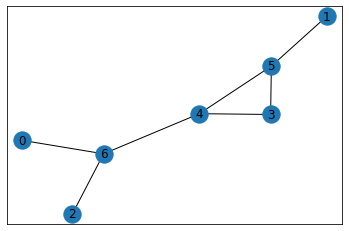

In [163]:
indiv = initialize()

topo =  [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0]


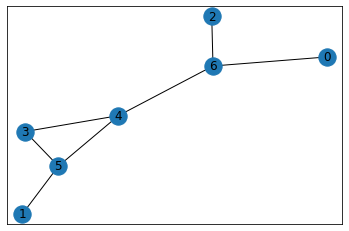

In [164]:
topo = indiv[0]
print("topo = ",topo)
A = get_adj(topo)
G = nx.from_numpy_array(A) #gr8
nx.draw_networkx(G)
plt.show()

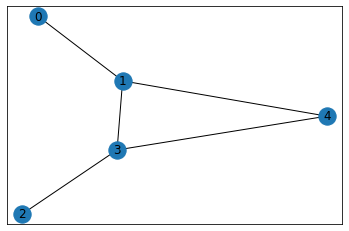

0.0


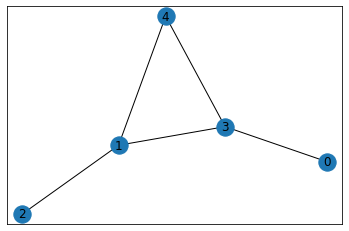

In [49]:
#MAP TEST NOT THAT GREAT TEST WITH EDIT DISTANCES TAKES TOO MUCH TIME, MAY BE FINE FOR LOWER NBR OF ARCHITECTURES
#test
#individual = initialize()
#individual[0] = [1,0,0,0,1,0,0,1,0,1] #linear graph
#individual[0] = [1,1,1,1,1,1,1,1,1,1] #fully connected graph
#individual[0] = [1,0,1,0,1,0,0,1,1,0] #parellel-like graph
#individual[2][1] = [i for i in range(27)]
#print(individual[2])

def select_k(spectrum, minimum_energy = 0.9):
    running_total = 0.0
    total = sum(spectrum)
    if total == 0.0:
        return len(spectrum)
    for i in range(len(spectrum)):
        running_total += spectrum[i]
        if running_total / total >= minimum_energy:
            return i + 1
    return len(spectrum)

laplacian1 = nx.spectrum.laplacian_spectrum(G)

def lambda_map(x):
    laplacian2 = nx.spectrum.laplacian_spectrum(x)
    k1 = select_k(laplacian1)
    k2 = select_k(laplacian2)
    k = min(k1, k2)
    similarity = sum((laplacian1[:k] - laplacian2[:k])**2)
    if similarity!=0:
        return (x,similarity)

graph_edit_dists = dict(map(lambda_map,gs))
#print(graph_edit_dists)

for k in graph_edit_dists:
    graph_edit_dists[k] = 1/graph_edit_dists[k] #see KNN slides module 2 intro to ML, might use gaussian distr : close dist => high weight
#print(graph_edit_dists)

#s = np.sum(list(graph_edit_dists))
#print(s)
#graph_normalized_dists = map(lambda x: float(x)/s, graph_edit_dists)
#print(list(graph_normalized_dists))
#print(list(graph_edit_dists))
#l = {G2: nx.graph_edit_distance(G,G2) for G2 in gs if nx.graph_edit_distance(G,G2)!=0 }


new_graph = random.choices(list(graph_edit_dists.keys()), weights=graph_edit_dists.values())[0]
print(nx.graph_edit_distance(G,new_graph))
nx.draw_networkx(new_graph)
plt.show()
#new_topo = topo(new_graph)

#res = np.mean(np.array([init(individual) for i in range(1)]))
#print("res = ",res)

In [ ]:
#KNN ALGO BRUTE FORCE CUSTOM DIST TOO SLOW, BUT GREAT DISTANCE DO NOT RUN

def select_k(spectrum, minimum_energy = 0.9):
    running_total = 0.0
    total = sum(spectrum)
    if total == 0.0:
        return len(spectrum)
    for i in range(len(spectrum)):
        running_total += spectrum[i]
        if running_total / total >= minimum_energy:
            return i + 1
    return len(spectrum)

def custom_dist(lg_topo,rg_topo):
    #print(lg_topo)
    #print(rg_topo)
    lg =  nx.from_numpy_array(get_adj(lg_topo))
    #nx.draw_networkx(lg)
    #plt.show()
    rg =  nx.from_numpy_array(get_adj(rg_topo))
    #nx.draw_networkx(rg)
    #plt.show()
    laplacian1 = nx.spectrum.laplacian_spectrum(lg)
    laplacian2 = nx.spectrum.laplacian_spectrum(rg)
    k1 = select_k(laplacian1)
    k2 = select_k(laplacian2)
    k = min(k1, k2)
    similarity = sum((laplacian1[:k] - laplacian2[:k])**2)
    return similarity

neigh = NearestNeighbors(n_neighbors=len(g_array),metric=custom_dist,algorithm='brute',n_jobs=-1)
neigh.fit(g_array)
dist,neighbors = neigh.kneighbors(g_array,return_distance=True) 
print(neighbors[10])

In [171]:
#KNN WITH EUCLIDIAN DIST FASTTTTTTTTTTTT
neigh = NearestNeighbors(n_neighbors=5,algorithm='kd_tree',n_jobs=-1) #n_neighbors = everyone, might limit it to get architectures that are not too different, to limit distance
neigh.fit(g_array)
dist,neighbors = neigh.kneighbors(g_array,return_distance=True) #global object used in mutation operator to find nearest neighbors to choose from them according to their distance.
print(neighbors[10])

[10  8 11  2 13]


new topo index:  1416
distance with new topo =  1.0
old topo :  [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0]


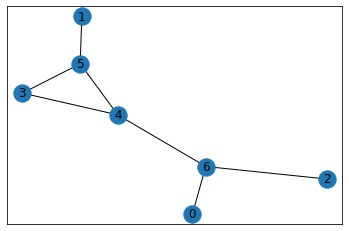

new topo :  [0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1]


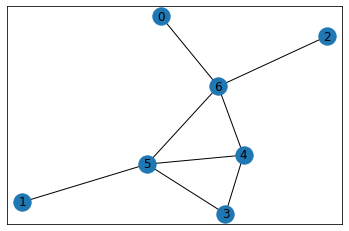

In [177]:
topo = indiv[0]
index_topo =[i for i in range(len(g_array)) if list(g_array[i])==topo][0]
dist_topo,neighbors_topo = dist[index_topo],neighbors[index_topo]
candidates = {neighbors_topo[i]:1/dist_topo[i] for i in range(len(dist_topo)) if dist_topo[i]!=0} #weight = 1/dist => closer dist => higher "chance" of being selected
new_topo_index = random.choices(list(candidates.keys()), weights=candidates.values())[0]
print("new topo index: ",new_topo_index)
print("distance with new topo = ",1/candidates[new_topo_index])
new_topo = g_array[new_topo_index]
print("old topo : ",topo)
A = get_adj(topo)
G = nx.from_numpy_array(A) #gr8
nx.draw_networkx(G)
plt.show()
print("new topo : ",new_topo)
A = get_adj(new_topo)
G = nx.from_numpy_array(A) #gr8
nx.draw_networkx(G)
plt.show()

In [ ]:
#OLD SOL, COMPUTE NEAREST NEIGHBOR AT EACH TIME => NOT OPTIMAL, BETTER COMPUTE ONCE AND FOR ALL ONCE
topo = individual[0]
dist,neighbors = neigh.kneighbors([topo],return_distance=True) 
dist,neighbors = dist[0],neighbors[0]
candidates = {neighbors[i]:1/dist[i] for i in range(len(dist)) if dist[i]!=0} #weight = 1/dist => closer dist => higher "chance" of being selected
new_topo_index = random.choices(list(candidates.keys()), weights=candidates.values())[0]
print("new topo index: ",new_topo_index)
new_topo = g_array[new_topo_index]
print("old topo : ",topo)
A = get_adj(topo)
G = nx.from_numpy_array(A) #gr8
nx.draw_networkx(G)
plt.show()
print("new topo : ",new_topo)
A = get_adj(new_topo)
G = nx.from_numpy_array(A) #gr8
nx.draw_networkx(G)
plt.show()

N5 T24 M10 J10 NO PENALTY features = nb deg >=3 + std machines


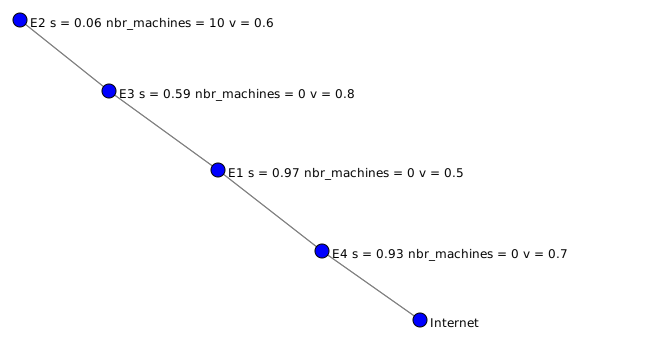

In [15]:
#with vuln sampled at each time
import numpy as np
N=5
best = [[0, 0, 0, 1, 0, 1, 1, 1, 0, 0], [0.9667204953908285, 0.06186624527407114, 0.5915789422051302, 0.9332070816204374], [[], [5, 4, 2, 7, 6, 9, 3, 0, 8, 1], [], []]]
best = [[0, 0, 0, 1, 0, 1, 1, 1, 0, 0], [0.97, 0.06, 0.59, 0.93], [[], [5, 4, 2, 7, 6, 9, 3, 0, 8, 1], [], []]]

global_vulnerabilities = [0, 0.5, 0.6, 0.8, 0.7]
topo = best[0]
sens = best[1]
nb_machines = [len(b) for b in best[2]]
adjacency = get_adj(topo)
adj = sparse.csr_matrix(adjacency)
labels = connected_components(adj)
names = ["Internet"]+["E"+str(i)+" s = "+str(sens[i-1])+" nbr_machines = "+str(nb_machines[i-1])+" v = "+str(global_vulnerabilities[i]) for i in range(1,N)]
image = svg_graph(adj,labels=labels,names=names)
x=SVG(image)

with open("N5T24M10J10NO_PENALTY_features_nb_deg_3_std_machines.svg", 'w') as f:
            f.write(image)
drawing = svg2rlg("N5T24M10J10NO_PENALTY_features_nb_deg_3_std_machines.svg")
renderPM.drawToFile(drawing, "N5T24M10J10NO_PENALTY_features_nb_deg_3_std_machines.png", fmt="PNG")

print("N5 T24 M10 J10 NO PENALTY features = nb deg >=3 + std machines")
display(x)

N7 T36 M10 J10 NO PENALTY features = nb deg >=3 + std machines


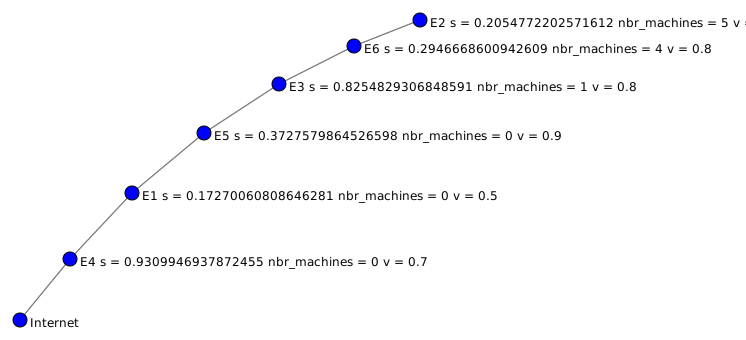

In [61]:
N = 7
best =[[0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0], [0.17270060808646281, 0.2054772202571612, 0.8254829306848591, 0.9309946937872455, 0.3727579864526598, 0.2946668600942609], [[], [6, 1, 5, 0, 2], [4], [], [], [9, 7, 3, 8]]]
global_vulnerabilities = [0, 0.5, 0.6, 0.8, 0.7, 0.9, 0.8]
topo = best[0]
sens = best[1]
nb_machines = [len(b) for b in best[2]]
adjacency = get_adj(topo)
adj = sparse.csr_matrix(adjacency)
labels = connected_components(adj)
names = ["Internet"]+["E"+str(i)+" s = "+str(sens[i-1])+" nbr_machines = "+str(nb_machines[i-1])+" v = "+str(global_vulnerabilities[i]) for i in range(1,N)]
image = svg_graph(adj,labels=labels,names=names)
x=SVG(image)
"""
with open("N7T36M10J10NO_PENALTY_features_nb_deg_3_std_machines.svg", 'w') as f:
            f.write(image)
drawing = svg2rlg("N7T36M10J10NO_PENALTY_features_nb_deg_3_std_machines.svg")
renderPM.drawToFile(drawing, "N7T36M10J10NO_PENALTY_features_nb_deg_3_std_machines.png", fmt="PNG")
"""
print("N7 T36 M10 J10 NO PENALTY features = nb deg >=3 + std machines")

display(x)

N5 T24 M10 J10 P0.01 PENALTYfeatures = nb deg >=3 + std machines


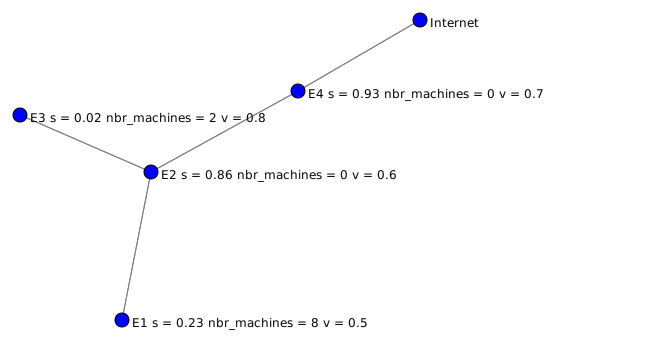

In [16]:
#with vuln sampled at each time
N = 5
best = [[0, 0, 0, 1, 1, 0, 0, 1, 1, 0], [0.22708529241878006, 0.8586544416898563, 0.01616780107947946, 0.9268392073965728], [[9, 3, 0, 7, 8, 1, 4, 6], [], [5, 2], []]]
best = [[0, 0, 0, 1, 1, 0, 0, 1, 1, 0], [0.23, 0.86, 0.02, 0.93], [[9, 3, 0, 7, 8, 1, 4, 6], [], [5, 2], []]]

global_vulnerabilities = [0, 0.5, 0.6, 0.8, 0.7]
topo = best[0]
sens = best[1]
nb_machines = [len(b) for b in best[2]]
adjacency = get_adj(topo)
adj = sparse.csr_matrix(adjacency)
labels = connected_components(adj)
names = ["Internet"]+["E"+str(i)+" s = "+str(sens[i-1])+" nbr_machines = "+str(nb_machines[i-1])+" v = "+str(global_vulnerabilities[i]) for i in range(1,N)]
image = svg_graph(adj,labels=labels,names=names)
x=SVG(image)

with open("N5T24M10J10P0.01PENALTYfeatures_nb_deg_3_std_machines.svg", 'w') as f:
            f.write(image)
drawing = svg2rlg("N5T24M10J10P0.01PENALTYfeatures_nb_deg_3_std_machines.svg")
renderPM.drawToFile(drawing, "N5T24M10J10P0.01PENALTYfeatures_nb_deg_3_std_machines.png", fmt="PNG")

print("N5 T24 M10 J10 P0.01 PENALTYfeatures = nb deg >=3 + std machines")

display(x)

N7 T36 M10 J10 P0.01 PENALTYfeatures = nb deg >=3 + std machines


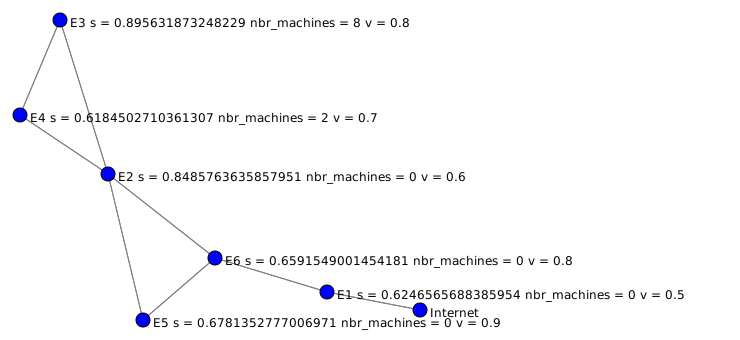

In [12]:
#with vuln sampled at each time
N = 7
best = [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1], [0.6246565688385954, 0.8485763635857951, 0.895631873248229, 0.6184502710361307, 0.6781352777006971, 0.6591549001454181], [[], [], [2, 0, 6, 5, 1, 4, 7, 8], [3, 9], [], []]]
global_vulnerabilities = [0, 0.5, 0.6, 0.8, 0.7, 0.9, 0.8]
topo = best[0]
sens = best[1]
nb_machines = [len(b) for b in best[2]]
adjacency = get_adj(topo)
adj = sparse.csr_matrix(adjacency)
labels = connected_components(adj)
names = ["Internet"]+["E"+str(i)+" s = "+str(sens[i-1])+" nbr_machines = "+str(nb_machines[i-1])+" v = "+str(global_vulnerabilities[i]) for i in range(1,N)]
image = svg_graph(adj,labels=labels,names=names)
x=SVG(image)
"""
with open("N7T36M10J10P0.01PENALTYfeatures_nb_deg_3_std_machines.svg", 'w') as f:
            f.write(image)
drawing = svg2rlg("N7T36M10J10P0.01PENALTYfeatures_nb_deg_3_std_machines.svg")
renderPM.drawToFile(drawing, "N7T36M10J10P0.01PENALTYfeatures_nb_deg_3_std_machines.png", fmt="PNG")
"""
print("N7 T36 M10 J10 P0.01 PENALTYfeatures = nb deg >=3 + std machines")

display(x)

N7 T36 M10 J10 P0.01 PENALTYfeatures = nb deg >=3 + std machines LONG


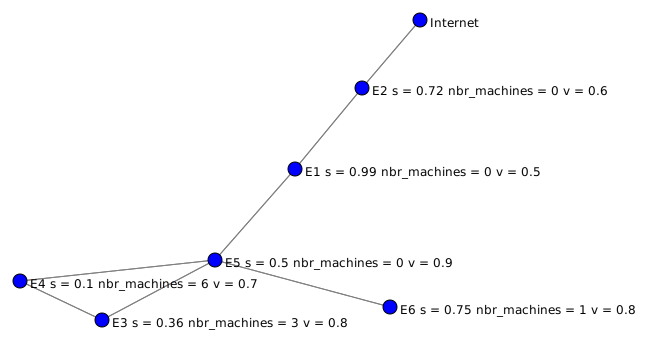

In [18]:
#with vuln sampled at each time
N = 7
best = [[0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1], [0.9946084261267267, 0.7162360389279556, 0.3597706721732261, 0.10056149193365538, 0.495821058480612, 0.7517898269786225], [[], [], [0, 9, 3], [5, 1, 2, 7, 4, 8], [], [6]]]
best = [[0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1], [0.99, 0.72, 0.36, 0.10, 0.50, 0.75], [[], [], [0, 9, 3], [5, 1, 2, 7, 4, 8], [], [6]]]

global_vulnerabilities = [0, 0.5, 0.6, 0.8, 0.7, 0.9, 0.8]
topo = best[0]
sens = best[1]
nb_machines = [len(b) for b in best[2]]
adjacency = get_adj(topo)
adj = sparse.csr_matrix(adjacency)
labels = connected_components(adj)
names = ["Internet"]+["E"+str(i)+" s = "+str(sens[i-1])+" nbr_machines = "+str(nb_machines[i-1])+" v = "+str(global_vulnerabilities[i]) for i in range(1,N)]
image = svg_graph(adj,labels=labels,names=names)
x=SVG(image)

with open("N7T36M10J10P0.01PENALTYfeatures_nb_deg_3_std_machines_LONG.svg", 'w') as f:
            f.write(image)
drawing = svg2rlg("N7T36M10J10P0.01PENALTYfeatures_nb_deg_3_std_machines_LONG.svg")
renderPM.drawToFile(drawing, "N7T36M10J10P0.01PENALTYfeatures_nb_deg_3_std_machines_LONG.png", fmt="PNG")

print("N7 T36 M10 J10 P0.01 PENALTYfeatures = nb deg >=3 + std machines LONG")

display(x)

C:\ProgramData\Anaconda3\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\ProgramData\Anaconda3\lib\site-packages\deap\creator.py:138: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


T =  36
N =  7
M =  10
iteration	containerSize	evals	nbUpdated	avg          	std         	min      	max     	elapsed
0        	91/800       	4000 	344      	[-7.50807692]	[1.40647583]	[-13.017]	[-5.257]	163.709
1        	92/800       	400  	36       	[-7.2721087] 	[1.21203312]	[-10.63] 	[-5.257]	16.2583
2        	92/800       	400  	28       	[-7.14747826]	[1.07191512]	[-10.63] 	[-5.257]	15.9027
3        	92/800       	400  	23       	[-7.03531522]	[1.00312861]	[-9.318] 	[-5.257]	15.8372
4        	92/800       	400  	16       	[-6.94629348]	[0.9193077] 	[-9.318] 	[-5.257]	15.5589
5        	92/800       	400  	20       	[-6.86073913]	[0.88025012]	[-8.802] 	[-5.257]	15.6984
6        	92/800       	400  	17       	[-6.76077174]	[0.87808374]	[-8.802] 	[-5.222]	15.8241
7        	92/800       	400  	15       	[-6.7191087] 	[0.87203691]	[-8.802] 	[-5.222]	15.629 
8        	92/800       	400  	10       	[-6.68217391]	[0.85568237]	[-8.802] 	[-5.222]	15.5444
9        	92/800       	400  	17     

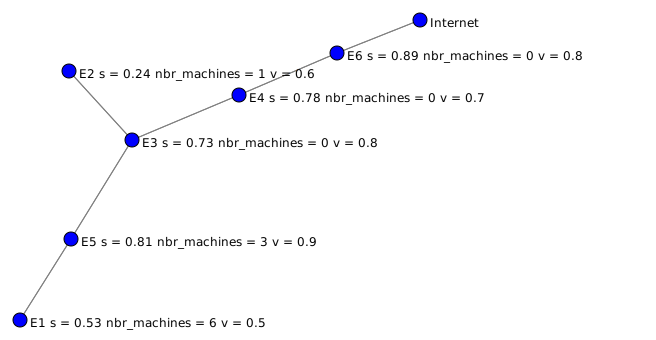

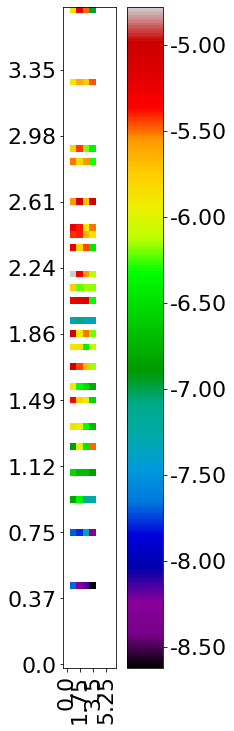

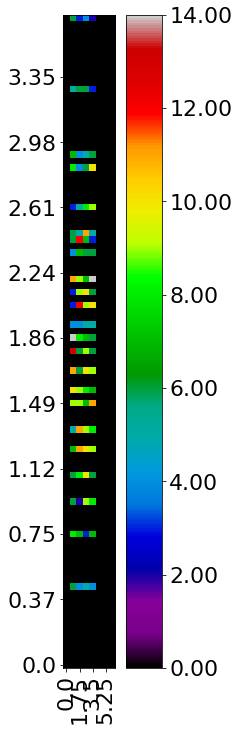

In [181]:
N=7 #WARNING, need to redefine it due to drawings modifying it.
#OPTIMISATION
###################################

def is_valid(topo): #1D topo #not used with KNN
    adjacency = get_adj(topo)
    adj = sparse.csr_matrix(adjacency)
    if(sum(topo)==0): #no edge
        return False
    labels = connected_components(adj)
    if(np.sum(labels)>0): #if graph is not connected, not valid
        return False
    adjacency_without_internet = np.delete(adjacency[1:],0,axis=1)
    if(np.sum(adjacency_without_internet)==0):
        return False
    labels = connected_components(adjacency_without_internet)
    if(np.sum(labels)>0): #if graph not connected without the Internet, not valid also
        return False
    
     #check if enclaves can route
    for enclave in range(1,N):
        if (sum(adjacency[enclave])>=2 and (route_traffic[enclave-1]==0)):
            return False

    return True


def partition (list_in, n):
    b=copy.deepcopy(list_in)
    random.shuffle(b)
    it = iter(b)
    size = len(b)
    res = []
    for i in range(n - 1,0,-1):
        s = random.randint(0, size -  0 * i)
        res += [list(islice(it,0,s))]
        size -= s
    res+=[list(it)]
    random.shuffle(res)
    return res


def initialize_old(): #old version when we didnt have graphillion
    topo = list(np.random.randint(low = 0,high=2,size=int(N*(N-1)/2)))
    if (not is_valid(topo)):
        return initialize_old()
    sensitivities = list(np.random.random_sample(size = N-1)) #internet has no sensitivity
    distribution = partition(list(range(0,M)),N-1) #internet has no "machines"
    return [topo,sensitivities,distribution]
    
def initialize():
    myit = gs.rand_iter()
    g = next(myit)
    #nx.draw_networkx(g) #draw network
    A = np.array(nx.to_numpy_matrix(g, nodelist=sorted(g.nodes())))
    topo = get_topo(A)
    topo = [int(t) for t in topo]
    sensitivities = list(np.random.random_sample(size = N-1)) #internet has no sensitivity
    distribution = partition(list(range(0,M)),N-1) #internet has no "machines"
    return [topo,sensitivities,distribution]


def evaluate(ind):
    """An example evaluation function. It takes an individual as input, and returns the pair ``(fitness, features)``, where ``fitness`` and ``features`` are sequences of scores."""
    #print("ind = ",len(ind))
    mat = get_adj(ind[0])
    score = np.mean(np.array([init(ind) for i in range(10)])).item() #more is better but slower
    #fit0 = sum(ind[0]) #old
    fit0 = sum(ind[0])
    fit1 = len([i for i in range(N) if sum(mat[i])>=3]) #nbr of enclaves that have degree >=3
    fit2 = np.std(np.array([len(l) for l in ind[2]])) #how sparse are machines
    fit3 = np.mean([global_vulnerabilities[i+1] for i in range(N-1) if len(ind[2][i])>=1 ] ) #mean vuln for enclaves that have mission device
    features = [fit1, fit2]
    return (score,), features
    

toolbox = base.Toolbox()
creator.create("FitnessMax", base.Fitness, weights=(1.0,))  # fitness
creator.create("Individual", list, fitness=creator.FitnessMax,features=list)
def individual():
    return creator.Individual(initialize())
#toolbox.register("initialize", initialize)
#toolbox.register("individual_old", tools.initRepeat, creator.Individual, toolbox.initialize, n=1)
toolbox.register("individual", individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate)
#toolbox.register("mate_topo", tools.cxTwoPoint)
def mate_strategy(parent1,parent2): #only mate 2 topo MUTATION NOT USED IN QD !!!!
    topo1, topo2 = tools.cxTwoPoint(parent1[0], parent2[0])
    res1,res2 = parent1,parent2
    res1[0] = topo1
    res2[0] = topo2
    a=2/0 #test to detect if its called in QD algo or not => IT IS NOT USED
    return res1,res2
toolbox.register("mate", mate_strategy)
#
toolbox.register("mutate_topo", tools.mutFlipBit, indpb=0.05)
eta = 20.0
mutation_pb = 0.4
toolbox.register("mutate_sens", tools.mutPolynomialBounded, low=0, up=1, eta=eta, indpb=mutation_pb)
def mutate_strategy(individual): #changes in place and return the individual 
    
    #print("MUTATION")
    """
    #mutation of 1D topo
    mutated_topo = toolbox.mutate_topo(individual[0])
    if (not isinstance(mutated_topo[0],list)):
        print("TOPO NOT A LIST")
    if (not is_valid(mutated_topo[0])): #check validity of mutated topo
        #print("NOT VALID MUTATION")
        return mutate_strategy(individual)
    """
    
    #mutation of topology with KNN algo euclidian dist
    topo = copy.deepcopy(individual[0])
    
    index_topo = [i for i in range(len(g_array)) if list(g_array[i])==topo][0]
    dist_topo,neighbors_topo = dist[index_topo],neighbors[index_topo] #global dist computed earlier via KNN algo (KNN is like a stochastic bit flip in constrained space)
    candidates = {neighbors_topo[i]:1/dist_topo[i] for i in range(len(dist_topo)) if dist_topo[i]!=0} #weight = 1/dist => closer dist => higher "chance" of being selected
    new_topo_index = random.choices(list(candidates.keys()), weights=candidates.values())[0]
    new_topo = g_array[new_topo_index] #new_topo is like the original topo but with a stochastically low number of changes in connections. 
    if(1/candidates[new_topo_index]>=2):
        print("distance >= 2")
        print("topo : ",topo)
        print("ntopo: ",new_topo)
    #mutation of sensibilities
    mutated_sens = toolbox.mutate_sens(individual[1])
    
    #mutation of valuable machine distribution
    distr = copy.deepcopy(individual[2])
    PC = random.choice(list(chain.from_iterable(distr)))
    index = [i for i in range(0,N-1) if PC in distr[i]]
    index = index[0]
    new_enclave = random.choice([i for i in range(N-1) if i!=index])
    mutated_distr = copy.deepcopy(distr)
    mutated_distr[index].remove(PC)
    mutated_distr[new_enclave].append(PC)
    
    #individual[0] = copy.deepcopy(mutated_topo[0]) #old
    individual[0] = copy.deepcopy(new_topo)
    individual[1] = copy.deepcopy(mutated_sens[0])
    individual[2] = copy.deepcopy(mutated_distr)
    return individual,
toolbox.register("mutate",mutate_strategy)
#
toolbox.register("select", tools.selRandom) # MAP-Elites = random selection on a grid container
###################################





print("T = ",T)
print("N = ",N)
print("M = ",M)
# Algorithm parameters
#    dimension = args.dimension                # The dimension of the target problem (i.e. genomes size)
nb_features = 2                            # The number of features to take into account in the container
list_max_var = [M]+[0]*(N-2)
sigma_max = np.std(list_max_var)

#nb_bins = [int(N*(N-1)/2)-(N-1)+1,int(sigma_max)] #old
nb_bins = [N+1,100] #for nbr of enclaves with degree >= 3
#    ind_domain = (0., 1.)                     # The domain (min/max values) of the individual genomes

#features_domain = [(N-1, int(N*(N-1)/2)), (0.,sigma_max)]      #old # The domain (min/max values) of the features
features_domain = [(0, N),(0,sigma_max)]
fitness_domain = [(-100, 0)]               # The domain (min/max values) of the fitness

init_batch_size = 4000                    # The number of evaluations of the initial batch ('batch' = population)
#3000 or 400 ?
#init_batch_size = 400
batch_size = 400                          # The number of evaluations in each subsequent batch
nb_iterations = 30                        # The number of iterations (i.e. times where a new batch is evaluated)
cxpb = 0.5                                #pseudo probability of mating : useless because no mating in QD
mutation_pb = 1                            # The probability of mutating each value of a genome
max_items_per_bin = 1                      # The number of items in each bin of the grid
verbose = True                         
show_warnings = True                      # Display warning and error messages. Set to True if you want to check if some individuals were out-of-bounds
log_base_path = "."
parallelismType = "multithreading" #"multithreading" or "none" or "concurrent" or "scoop" or "multiprocessing" : best one so far

# Update and print seed
seed = 7
np.random.seed(seed)
random.seed(seed)


# Build a dict storing all relevant infos
results_infos = {}
#   results_infos['dimension'] = dimension
#   results_infos['ind_domain'] = ind_domain
results_infos['features_domain'] = features_domain
results_infos['fitness_domain'] = fitness_domain
results_infos['nb_bins'] = nb_bins
results_infos['init_batch_size'] = init_batch_size
results_infos['nb_iterations'] = nb_iterations
results_infos['batch_size'] = batch_size
#   results_infos['mutation_pb'] = mutation_pb
#   results_infos['eta'] = eta

grid = containers.Grid(shape=nb_bins, max_items_per_bin=max_items_per_bin, fitness_domain=fitness_domain, features_domain=features_domain,storage_type=list)

with ParallelismManager(parallelismType,toolbox=toolbox) as pMgr:
    algo = DEAPQDAlgorithm(pMgr.toolbox, grid, init_batch_size = init_batch_size, batch_size = batch_size, niter = nb_iterations, 
                           mutpb = mutation_pb,
            verbose = verbose, show_warnings = show_warnings, results_infos = results_infos, log_base_path = log_base_path)
    # Run the illumination process !
    algo.run()

    #best = algo.optimise(eval_fn, executor = pMgr.executor, batch_mode=False) # Disable batch_mode (steady-state mode) to ask/tell new individuals without waiting the completion of each batch

# Print results info
print("Total elapsed: ",algo.total_elapsed)
#print(grid.summary())
print("#########################################################")
print("QD score = ",grid.qd_score())
print(grid.best)
plot_path = os.path.join(log_base_path, "performancesGrid2.pdf")
plotGridSubplots(grid.quality_array[... ,0], plot_path, plt.get_cmap("nipy_spectral"), grid.features_domain, grid.fitness_extrema[0], nbTicks=None)
#print("\nA plot of the performance grid was saved in '%s'." % os.path.abspath(plot_path))

plot_path = os.path.join(log_base_path, "activityGrid2.pdf")
plotGridSubplots(grid.activity_per_bin, plot_path, plt.get_cmap("nipy_spectral"), grid.features_domain, [0, np.max(grid.activity_per_bin)], nbTicks=None)
#print("\nA plot of the activity grid was saved in '%s'." % os.path.abspath(plot_path))

#print("All results are available in the '%s' pickle file." % algo.final_filename)


#print best architecture

best = grid.best
topo = best[0]
sens = best[1]
nb_machines = [len(b) for b in best[2]]
adjacency = get_adj(topo)
adj = sparse.csr_matrix(adjacency)
labels = connected_components(adj)
names = ["Internet"]+["E"+str(i)+" s = "+str(round(sens[i-1],2))+" nbr_machines = "+str(nb_machines[i-1])+" v = "+str(global_vulnerabilities[i]) for i in range(1,N)]
image = svg_graph(adj,labels=labels,names=names)
x=SVG(image)
"""
with open("N7T36M10J10P0.01PENALTYfeatures_nb_deg_3_std_machines_LONG.svg", 'w') as f:
            f.write(image)
drawing = svg2rlg("N7T36M10J10P0.01PENALTYfeatures_nb_deg_3_std_machines_LONG.svg")
renderPM.drawToFile(drawing, "N7T36M10J10P0.01PENALTYfeatures_nb_deg_3_std_machines_LONG.png", fmt="PNG")
"""
print("N",N,"T",T,"M",M,"J",int(JUNK_MACHINES_NB/2),"P",penalty_coeff,"PENALTY features = nb deg >=3 + std machines LONG")

display(x)
    


N 7 T 36 M 10 J 10 P 0.01 PENALTY features = nb deg >=3 + std machines LONG


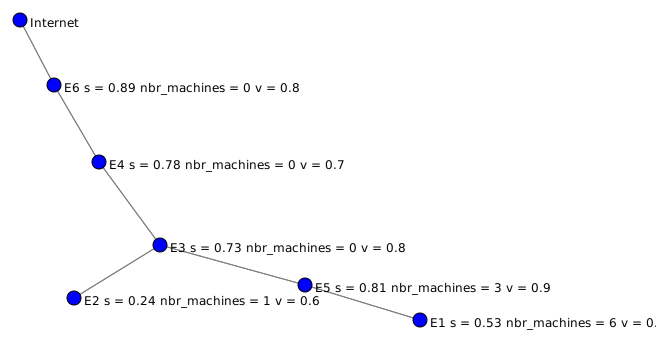

In [182]:
#grid.best

N = 7
best = grid.best

global_vulnerabilities = [0, 0.5, 0.6, 0.8, 0.7, 0.9, 0.8]
topo = best[0]
sens = best[1]
nb_machines = [len(b) for b in best[2]]
adjacency = get_adj(topo)
adj = sparse.csr_matrix(adjacency)
labels = connected_components(adj)
names = ["Internet"]+["E"+str(i)+" s = "+str(round(sens[i-1],2))+" nbr_machines = "+str(nb_machines[i-1])+" v = "+str(global_vulnerabilities[i]) for i in range(1,N)]
image = svg_graph(adj,labels=labels,names=names)
x=SVG(image)
"""
with open("N7T36M10J10P0.01PENALTYfeatures_nb_deg_3_std_machines_LONG.svg", 'w') as f:
            f.write(image)
drawing = svg2rlg("N7T36M10J10P0.01PENALTYfeatures_nb_deg_3_std_machines_LONG.svg")
renderPM.drawToFile(drawing, "N7T36M10J10P0.01PENALTYfeatures_nb_deg_3_std_machines_LONG.png", fmt="PNG")
"""
print("N",N,"T",T,"M",M,"J",int(JUNK_MACHINES_NB/2),"P",penalty_coeff,"PENALTY features = nb deg >=3 + std machines LONG")

display(x)

N 5 T 24 M 10 J 10 P 0.01 PENALTY features = nb deg >=3 + std machines LONG


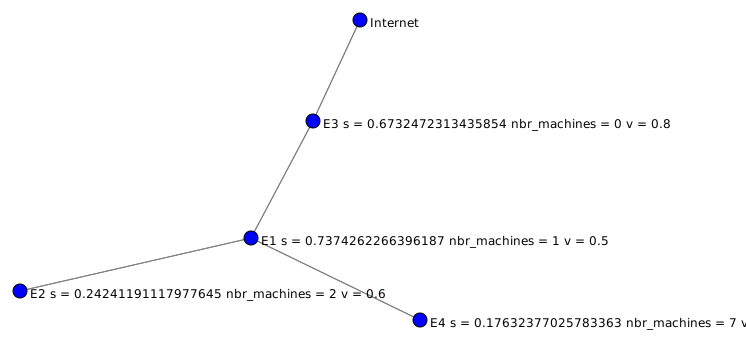

In [37]:
#grid.best

N = 5
best = [[0, 0, 1, 0, 1, 1, 1, 0, 0, 0], [0.7374262266396187, 0.24241191117977645, 0.6732472313435854, 0.17632377025783363], [[9], [7, 1], [], [3, 6, 4, 5, 2, 8, 0]]]


global_vulnerabilities = [0, 0.5, 0.6, 0.8, 0.7]
topo = best[0]
sens = best[1]
nb_machines = [len(b) for b in best[2]]
adjacency = get_adj(topo)
adj = sparse.csr_matrix(adjacency)
labels = connected_components(adj)
names = ["Internet"]+["E"+str(i)+" s = "+str(sens[i-1])+" nbr_machines = "+str(nb_machines[i-1])+" v = "+str(global_vulnerabilities[i]) for i in range(1,N)]
image = svg_graph(adj,labels=labels,names=names)
x=SVG(image)
"""
with open("N7T36M10J10P0.01PENALTYfeatures_nb_deg_3_std_machines_LONG.svg", 'w') as f:
            f.write(image)
drawing = svg2rlg("N7T36M10J10P0.01PENALTYfeatures_nb_deg_3_std_machines_LONG.svg")
renderPM.drawToFile(drawing, "N7T36M10J10P0.01PENALTYfeatures_nb_deg_3_std_machines_LONG.png", fmt="PNG")
"""
print("N",N,"T",T,"M",M,"J",int(JUNK_MACHINES_NB/2),"P",penalty_coeff,"PENALTY features = nb deg >=3 + std machines LONG")

display(x)

N 5 T 24 M 10 J 10 P 0.01 PENALTY features = nb deg >=3 + std machines LONG


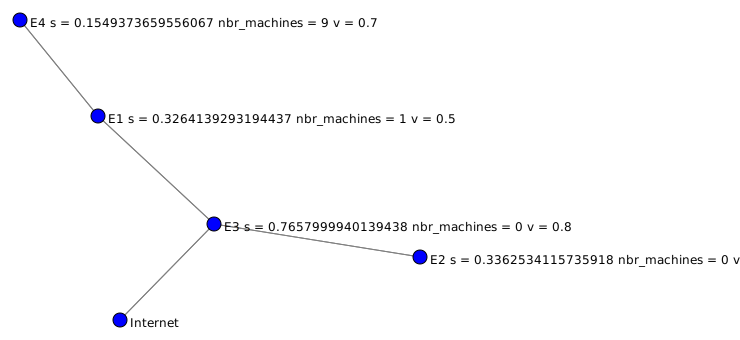

In [34]:
#to run on anaconda
#jupyter notebook --generate-config
#2. Open the jupyter_notebook_config.py file and edit the following property:
#NotebookApp.max_buffer_size = your desired value
#c.NotebookApp.max_buffer_size = your desired value
#c.NotebookApp.max_buffer_size = 3000000000
#jupyter notebook --NotebookApp.max_buffer_size=3000000000

#only E1 and E3 can route traffic

#grid.best

N = 5
best = [[0, 0, 1, 0, 0, 1, 1, 1, 0, 0], [0.3264139293194437, 0.3362534115735918, 0.7657999940139438, 0.1549373659556067], [[9], [], [], [6, 5, 2, 8, 0, 1, 4, 3, 7]]]

global_vulnerabilities = [0, 0.5, 0.6, 0.8, 0.7]
topo = best[0]
sens = best[1]
nb_machines = [len(b) for b in best[2]]
adjacency = get_adj(topo)
adj = sparse.csr_matrix(adjacency)
labels = connected_components(adj)
names = ["Internet"]+["E"+str(i)+" s = "+str(sens[i-1])+" nbr_machines = "+str(nb_machines[i-1])+" v = "+str(global_vulnerabilities[i]) for i in range(1,N)]
image = svg_graph(adj,labels=labels,names=names)
x=SVG(image)
"""
with open("N7T36M10J10P0.01PENALTYfeatures_nb_deg_3_std_machines_LONG.svg", 'w') as f:
            f.write(image)
drawing = svg2rlg("N7T36M10J10P0.01PENALTYfeatures_nb_deg_3_std_machines_LONG.svg")
renderPM.drawToFile(drawing, "N7T36M10J10P0.01PENALTYfeatures_nb_deg_3_std_machines_LONG.png", fmt="PNG")
"""
print("N",N,"T",T,"M",M,"J",int(JUNK_MACHINES_NB/2),"P",penalty_coeff,"PENALTY features = nb deg >=3 + std machines LONG")

display(x)